## Build an MTH5 and Operate the Aurora Pipeline

This notebook pulls MT miniSEED data from the IRIS Dataselect web service and produces MTH5 out of it. It outlines the process of making an MTH5 file, generating a processing config, and running the Aurora processor.

It assumes that aurora, mth5, and mt_metadata have all been installed.

In this "new" version, the workflow has changed somewhat.  

1. The process_mth5 call works with a dataset dataframe, rather than a single run_id
2. The config object is now based on the mt_metadata.base Base class
3. Remote reference processing is supported (at least in theory)

### 0. Flow of this notebook

Section 1: Here we do imports and construct a table of the data that we will access to build the mth5.  Note that there is no explanation here as to the table source -- a future update can show how to create such a table from IRIS data_availability tools

Seciton 2: the metadata and the data are accessed, and the mth5 is created and stored.

Section 3: Aurora is used to process the data

In [1]:
# Use this for developing
%load_ext autoreload
%autoreload 2


In [2]:
# Required imports for the program. 
from pathlib import Path
import pandas as pd
import warnings

from mth5 import mth5, timeseries
from mth5.clients.fdsn import FDSN
from mth5.clients.make_mth5 import MakeMTH5
from mth5.utils.helpers import initialize_mth5
from mt_metadata.utils.mttime import get_now_utc, MTime
from aurora.config import BANDS_DEFAULT_FILE
from aurora.config.config_creator import ConfigCreator
from aurora.pipelines.process_mth5 import process_mth5
from aurora.transfer_function.kernel_dataset import KernelDataset
from aurora.pipelines.run_summary import RunSummary

warnings.filterwarnings('ignore')

Error in callback <bound method AutoreloadMagics.pre_run_cell of <IPython.extensions.autoreload.AutoreloadMagics object at 0x106932090>> (for pre_run_cell):


TypeError: AutoreloadMagics.pre_run_cell() takes 1 positional argument but 2 were given

/Users/laurakeyson/Desktop/aurora_test/aurora/aurora/time_series/window_helpers.py:76: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit


## 1. Build an MTH5 file from information extracted by IRIS

- If you have already built an MTH5 you can skip this section 


Set path so MTH5 file builds to current working directory. 

In [3]:
default_path = Path().cwd()
default_path

Error in callback <bound method AutoreloadMagics.pre_run_cell of <IPython.extensions.autoreload.AutoreloadMagics object at 0x106932090>> (for pre_run_cell):


TypeError: AutoreloadMagics.pre_run_cell() takes 1 positional argument but 2 were given

PosixPath('/Users/laurakeyson/Desktop/aurora_test/aurora/docs/examples')

Select mth5 file version

In [4]:
# mth5_version = '0.1.0'
mth5_version = '0.2.0'


Error in callback <bound method AutoreloadMagics.pre_run_cell of <IPython.extensions.autoreload.AutoreloadMagics object at 0x106932090>> (for pre_run_cell):


TypeError: AutoreloadMagics.pre_run_cell() takes 1 positional argument but 2 were given

In [5]:
# Initialize the Make MTH5 code. 
maker = MakeMTH5(mth5_version=mth5_version)
maker.client = "IRIS"
maker.interact = True

# Initalize an FDSN object to access column names for request df
fdsn_obj = FDSN()

Error in callback <bound method AutoreloadMagics.pre_run_cell of <IPython.extensions.autoreload.AutoreloadMagics object at 0x106932090>> (for pre_run_cell):


TypeError: AutoreloadMagics.pre_run_cell() takes 1 positional argument but 2 were given

### 1A: Specify the data to access from IRIS

Note that here we explicitly prescribe the data, but this dataframe could be built from IRIS data availability tools in a programatic way

In [6]:
# Generate data frame of FDSN Network, Station, Location, Channel, Startime, Endtime codes of interest

CAS04LQE = ['8P', 'CAS04', '', 'LQE', '2020-06-02T19:00:00', '2020-07-13T19:00:00']
CAS04LQN = ['8P', 'CAS04', '', 'LQN', '2020-06-02T19:00:00', '2020-07-13T19:00:00']
CAS04BFE = ['8P', 'CAS04', '', 'LFE', '2020-06-02T19:00:00', '2020-07-13T19:00:00']
CAS04BFN = ['8P', 'CAS04', '', 'LFN', '2020-06-02T19:00:00', '2020-07-13T19:00:00']
CAS04BFZ = ['8P', 'CAS04', '', 'LFZ', '2020-06-02T19:00:00', '2020-07-13T19:00:00']

request_list = [CAS04LQE, CAS04LQN, CAS04BFE, CAS04BFN, CAS04BFZ]

# Turn list into dataframe
request_df =  pd.DataFrame(request_list, columns=fdsn_obj.request_columns)

Error in callback <bound method AutoreloadMagics.pre_run_cell of <IPython.extensions.autoreload.AutoreloadMagics object at 0x106932090>> (for pre_run_cell):


TypeError: AutoreloadMagics.pre_run_cell() takes 1 positional argument but 2 were given

In [7]:
# Inspect the dataframe
request_df

Error in callback <bound method AutoreloadMagics.pre_run_cell of <IPython.extensions.autoreload.AutoreloadMagics object at 0x106932090>> (for pre_run_cell):


TypeError: AutoreloadMagics.pre_run_cell() takes 1 positional argument but 2 were given

,network,station,location,channel,start,end
0,8P,CAS04,,LQE,2020-06-02T19:00:00,2020-07-13T19:00:00
1,8P,CAS04,,LQN,2020-06-02T19:00:00,2020-07-13T19:00:00
2,8P,CAS04,,LFE,2020-06-02T19:00:00,2020-07-13T19:00:00
3,8P,CAS04,,LFN,2020-06-02T19:00:00,2020-07-13T19:00:00
4,8P,CAS04,,LFZ,2020-06-02T19:00:00,2020-07-13T19:00:00


In [8]:
# Request the inventory information from IRIS
inventory = fdsn_obj.get_inventory_from_df(request_df, data=False)

Error in callback <bound method AutoreloadMagics.pre_run_cell of <IPython.extensions.autoreload.AutoreloadMagics object at 0x106932090>> (for pre_run_cell):


TypeError: AutoreloadMagics.pre_run_cell() takes 1 positional argument but 2 were given

In [9]:
# Inspect the inventory
inventory

Error in callback <bound method AutoreloadMagics.pre_run_cell of <IPython.extensions.autoreload.AutoreloadMagics object at 0x106932090>> (for pre_run_cell):


TypeError: AutoreloadMagics.pre_run_cell() takes 1 positional argument but 2 were given

(Inventory created at 2023-10-31T20:39:33.281316Z
	Created by: ObsPy 1.4.0
		    https://www.obspy.org
	Sending institution: MTH5
	Contains:
		Networks (1):
			8P
		Stations (1):
			8P.CAS04 (Corral Hollow, CA, USA)
		Channels (8):
			8P.CAS04..LFZ, 8P.CAS04..LFN, 8P.CAS04..LFE, 8P.CAS04..LQN (2x), 
			8P.CAS04..LQE (3x),
 0 Trace(s) in Stream:
)

Builds an MTH5 file from the user defined database. 

With the mth5 object set, we are ready to actually request the data from the fdsn client (IRIS) and save it to an MTH5 file.  This process builds an MTH5 file and can take some time depending on how much data is requested.  

Note: `interact` keeps the MTH5 open after it is done building


In [10]:
mth5_object = maker.from_fdsn_client(request_df)

Error in callback <bound method AutoreloadMagics.pre_run_cell of <IPython.extensions.autoreload.AutoreloadMagics object at 0x106932090>> (for pre_run_cell):


TypeError: AutoreloadMagics.pre_run_cell() takes 1 positional argument but 2 were given

2023-10-31T13:39:33.746339-0700 | WARNING | mth5.mth5 | open_mth5 | 8P_CAS04.h5 will be overwritten in 'w' mode
2023-10-31T13:39:33.888341-0700 | INFO | mth5.mth5 | _initialize_file | Initialized MTH5 0.2.0 file /Users/laurakeyson/Desktop/aurora_test/aurora/docs/examples/8P_CAS04.h5 in mode w
2023-10-31T13:39:59.418677-0700 | INFO | mt_metadata.timeseries.filters.obspy_stages | create_filter_from_stage | Converting PoleZerosResponseStage electric_si_units to a CoefficientFilter.
2023-10-31T13:39:59.425195-0700 | INFO | mt_metadata.timeseries.filters.obspy_stages | create_filter_from_stage | Converting PoleZerosResponseStage electric_dipole_92.000 to a CoefficientFilter.
2023-10-31T13:39:59.449536-0700 | INFO | mt_metadata.timeseries.filters.obspy_stages | create_filter_from_stage | Converting PoleZerosResponseStage electric_si_units to a CoefficientFilter.
2023-10-31T13:39:59.454017-0700 | INFO | mt_metadata.timeseries.filters.obspy_stages | create_filter_from_stage | Converting PoleZe

### 1B: Examine and Update the MTH5 object

With the open MTH5 Object, we can start to examine what is in it. For example, retrieve the filename and file_version. You can additionally do things such as getting the station information and edit it by setting a new value, in this case the declination model. 

In [11]:
mth5_object

Error in callback <bound method AutoreloadMagics.pre_run_cell of <IPython.extensions.autoreload.AutoreloadMagics object at 0x106932090>> (for pre_run_cell):


TypeError: AutoreloadMagics.pre_run_cell() takes 1 positional argument but 2 were given

/:
    |- Group: Experiment
    --------------------
        |- Group: Reports
        -----------------
        |- Group: Standards
        -------------------
            --> Dataset: summary
            ......................
        |- Group: Surveys
        -----------------
            |- Group: CONUS_South
            ---------------------
                |- Group: Filters
                -----------------
                    |- Group: coefficient
                    ---------------------
                        |- Group: electric_analog_to_digital
                        ------------------------------------
                        |- Group: electric_dipole_92.000
                        --------------------------------
                        |- Group: electric_si_units
                        ---------------------------
                        |- Group: magnetic_analog_to_digital
                        ------------------------------------
                    |- Group: fap
   

In [12]:
mth5_path = mth5_object.filename

Error in callback <bound method AutoreloadMagics.pre_run_cell of <IPython.extensions.autoreload.AutoreloadMagics object at 0x106932090>> (for pre_run_cell):


TypeError: AutoreloadMagics.pre_run_cell() takes 1 positional argument but 2 were given

In [13]:
mth5_object.file_version


Error in callback <bound method AutoreloadMagics.pre_run_cell of <IPython.extensions.autoreload.AutoreloadMagics object at 0x106932090>> (for pre_run_cell):


TypeError: AutoreloadMagics.pre_run_cell() takes 1 positional argument but 2 were given

'0.2.0'

In [14]:
mth5_object.close_mth5()

Error in callback <bound method AutoreloadMagics.pre_run_cell of <IPython.extensions.autoreload.AutoreloadMagics object at 0x106932090>> (for pre_run_cell):


TypeError: AutoreloadMagics.pre_run_cell() takes 1 positional argument but 2 were given

2023-10-31T13:40:01.888826-0700 | INFO | mth5.mth5 | close_mth5 | Flushing and closing /Users/laurakeyson/Desktop/aurora_test/aurora/docs/examples/8P_CAS04.h5


In [15]:
mth5_object = initialize_mth5(mth5_path)

Error in callback <bound method AutoreloadMagics.pre_run_cell of <IPython.extensions.autoreload.AutoreloadMagics object at 0x106932090>> (for pre_run_cell):


TypeError: AutoreloadMagics.pre_run_cell() takes 1 positional argument but 2 were given

### 1C: Optionally Update Metdata:

In [16]:
# Edit and update the MTH5 metadata 
s = mth5_object.get_station("CAS04", survey="CONUS_South")
print(s.metadata.location.declination.model)
s.metadata.location.declination.model = 'IGRF'
print(s.metadata.location.declination.model)
s.write_metadata()    # writes to file mth5_filename

Error in callback <bound method AutoreloadMagics.pre_run_cell of <IPython.extensions.autoreload.AutoreloadMagics object at 0x106932090>> (for pre_run_cell):


TypeError: AutoreloadMagics.pre_run_cell() takes 1 positional argument but 2 were given

IGRF-13
IGRF


In [17]:
# Print some info about the mth5 
mth5_filename = mth5_object.filename
version = mth5_object.file_version
print(f" Filename: {mth5_filename} \n Version: {version}")


Error in callback <bound method AutoreloadMagics.pre_run_cell of <IPython.extensions.autoreload.AutoreloadMagics object at 0x106932090>> (for pre_run_cell):


TypeError: AutoreloadMagics.pre_run_cell() takes 1 positional argument but 2 were given

 Filename: /Users/laurakeyson/Desktop/aurora_test/aurora/docs/examples/8P_CAS04.h5 
 Version: 0.2.0


In [18]:
# Get the available stations and runs from the MTH5 object
mth5_object.channel_summary.summarize()
ch_summary = mth5_object.channel_summary.to_dataframe()

Error in callback <bound method AutoreloadMagics.pre_run_cell of <IPython.extensions.autoreload.AutoreloadMagics object at 0x106932090>> (for pre_run_cell):


TypeError: AutoreloadMagics.pre_run_cell() takes 1 positional argument but 2 were given

## 2: Process Data
If MTH5 file already exists you can start here if you dont want to execute the previous code to get data again.

In [19]:
interact = False
if interact:
    pass
else:
    h5_path = default_path.joinpath("8P_CAS04.h5")
    mth5_object = initialize_mth5(h5_path, mode="a", file_version=mth5_version)
    ch_summary = mth5_object.channel_summary.to_dataframe()



Error in callback <bound method AutoreloadMagics.pre_run_cell of <IPython.extensions.autoreload.AutoreloadMagics object at 0x106932090>> (for pre_run_cell):


TypeError: AutoreloadMagics.pre_run_cell() takes 1 positional argument but 2 were given

### Generate an Aurora Configuration file using MTH5 as an input

Up to this point, we have used mth5 and mt_metadata, but haven't yet used aurora. So we will use the MTH5 that we just created (and examined and updated) as input into Aurora.



### Channel Summary

This is a very useful datastructure inside the mth5.   It acts basically like an index of available data at the channel-run level, i.e. there is one row for every contiguous chunk of time-series recorded by an electric dipole or magnetometer

In [20]:
ch_summary

Error in callback <bound method AutoreloadMagics.pre_run_cell of <IPython.extensions.autoreload.AutoreloadMagics object at 0x106932090>> (for pre_run_cell):


TypeError: AutoreloadMagics.pre_run_cell() takes 1 positional argument but 2 were given

,survey,station,run,latitude,longitude,elevation,component,start,end,n_samples,sample_rate,measurement_type,azimuth,tilt,units,hdf5_reference,run_hdf5_reference,station_hdf5_reference
0,CONUS South,CAS04,a,37.633351,-121.468382,329.3875,ex,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,electric,13.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
1,CONUS South,CAS04,a,37.633351,-121.468382,329.3875,ey,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,electric,103.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
2,CONUS South,CAS04,a,37.633351,-121.468382,329.3875,hx,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,magnetic,13.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
3,CONUS South,CAS04,a,37.633351,-121.468382,329.3875,hy,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,magnetic,103.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
4,CONUS South,CAS04,a,37.633351,-121.468382,329.3875,hz,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,magnetic,0.0,90.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
5,CONUS South,CAS04,b,37.633351,-121.468382,329.3875,ex,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,847649,1.0,electric,13.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
6,CONUS South,CAS04,b,37.633351,-121.468382,329.3875,ey,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,847649,1.0,electric,103.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
7,CONUS South,CAS04,b,37.633351,-121.468382,329.3875,hx,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,847649,1.0,magnetic,13.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
8,CONUS South,CAS04,b,37.633351,-121.468382,329.3875,hy,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,847649,1.0,magnetic,103.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
9,CONUS South,CAS04,b,37.633351,-121.468382,329.3875,hz,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,847649,1.0,magnetic,0.0,90.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>


The Channel summary has a lot of uses, below we use it to check if the data have mixed sample rates, and to get a list of available stations

In [21]:
available_runs = ch_summary.run.unique()
sr = ch_summary.sample_rate.unique()
if len(sr) != 1:
    print('Only one sample rate per run is available')
    
available_stations = ch_summary.station.unique()
print(f"Available stations: {available_stations}")

Error in callback <bound method AutoreloadMagics.pre_run_cell of <IPython.extensions.autoreload.AutoreloadMagics object at 0x106932090>> (for pre_run_cell):


TypeError: AutoreloadMagics.pre_run_cell() takes 1 positional argument but 2 were given

Available stations: ['CAS04']


### Run Summary

A cousin of the channel summary is the Run Summary.
This is a condensed version of the channel summary, with one row per continuous acquistion run at a station.

The run summary can be accessed from an open mth5 object, or from an iterable of h5 paths as in the example below


In [22]:
mth5_run_summary = RunSummary()
h5_path = default_path.joinpath("8P_CAS04.h5")
mth5_run_summary.from_mth5s([h5_path,])
run_summary = mth5_run_summary.clone()
run_summary.df

Error in callback <bound method AutoreloadMagics.pre_run_cell of <IPython.extensions.autoreload.AutoreloadMagics object at 0x106932090>> (for pre_run_cell):


TypeError: AutoreloadMagics.pre_run_cell() takes 1 positional argument but 2 were given

2023-10-31T13:40:02.155717-0700 | INFO | mth5.mth5 | close_mth5 | Flushing and closing /Users/laurakeyson/Desktop/aurora_test/aurora/docs/examples/8P_CAS04.h5


,survey,station_id,run_id,start,end,sample_rate,input_channels,output_channels,channel_scale_factors,valid,mth5_path
0,CONUS South,CAS04,a,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,1.0,"[hx, hy]","[ex, ey, hz]","{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",True,/Users/laurakeyson/Desktop/aurora_test/aurora/...
1,CONUS South,CAS04,b,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,1.0,"[hx, hy]","[ex, ey, hz]","{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",True,/Users/laurakeyson/Desktop/aurora_test/aurora/...
2,CONUS South,CAS04,c,2020-06-12 18:32:17+00:00,2020-07-01 17:32:59+00:00,1.0,"[hx, hy]","[ex, ey, hz]","{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",True,/Users/laurakeyson/Desktop/aurora_test/aurora/...
3,CONUS South,CAS04,d,2020-07-01 19:36:55+00:00,2020-07-13 19:00:00+00:00,1.0,"[hx, hy]","[ex, ey, hz]","{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",True,/Users/laurakeyson/Desktop/aurora_test/aurora/...


Now we have a dataframe of the available runs to process from the MTH5 

Sometimes we just want to look at the survey, station, run, and time intervals
we can for that we can call mini_summary

In [23]:
run_summary.mini_summary

Error in callback <bound method AutoreloadMagics.pre_run_cell of <IPython.extensions.autoreload.AutoreloadMagics object at 0x106932090>> (for pre_run_cell):


TypeError: AutoreloadMagics.pre_run_cell() takes 1 positional argument but 2 were given

,survey,station_id,run_id,start,end
0,CONUS South,CAS04,a,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00
1,CONUS South,CAS04,b,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00
2,CONUS South,CAS04,c,2020-06-12 18:32:17+00:00,2020-07-01 17:32:59+00:00
3,CONUS South,CAS04,d,2020-07-01 19:36:55+00:00,2020-07-13 19:00:00+00:00


But here are the columns in the run summary

In [24]:
run_summary.df.columns

Error in callback <bound method AutoreloadMagics.pre_run_cell of <IPython.extensions.autoreload.AutoreloadMagics object at 0x106932090>> (for pre_run_cell):


TypeError: AutoreloadMagics.pre_run_cell() takes 1 positional argument but 2 were given

Index(['survey', 'station_id', 'run_id', 'start', 'end', 'sample_rate',
       'input_channels', 'output_channels', 'channel_scale_factors', 'valid',
       'mth5_path'],
      dtype='object')

 Make your own mini summary by choosing columns

In [25]:
coverage_short_list_columns = ["survey", 'station_id', 'run_id', 'start', 'end', ]
run_summary.df[coverage_short_list_columns]

Error in callback <bound method AutoreloadMagics.pre_run_cell of <IPython.extensions.autoreload.AutoreloadMagics object at 0x106932090>> (for pre_run_cell):


TypeError: AutoreloadMagics.pre_run_cell() takes 1 positional argument but 2 were given

,survey,station_id,run_id,start,end
0,CONUS South,CAS04,a,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00
1,CONUS South,CAS04,b,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00
2,CONUS South,CAS04,c,2020-06-12 18:32:17+00:00,2020-07-01 17:32:59+00:00
3,CONUS South,CAS04,d,2020-07-01 19:36:55+00:00,2020-07-13 19:00:00+00:00


### Kernel Dataset

This is like a run summary, but for a single station or a pair of stations.
It is used to specify the inputs to aurora processing.

It takes a run_summary and a station name, and optionally, a remote reference station name

It is made _based on the available data_ in the MTH5 archive.

Syntax:
kernel_dataset.from_run_summary(run_summary, local_station_id, reference_station_id)

By Default, all runs will be processed

To restrict to processing a single run, or a list of runs, we can either tell KernelDataset to keep or drop a station_run dictionary. 


In [26]:
kernel_dataset = KernelDataset()
kernel_dataset.from_run_summary(run_summary, "CAS04")
kernel_dataset.mini_summary

Error in callback <bound method AutoreloadMagics.pre_run_cell of <IPython.extensions.autoreload.AutoreloadMagics object at 0x106932090>> (for pre_run_cell):


TypeError: AutoreloadMagics.pre_run_cell() takes 1 positional argument but 2 were given

,survey,station_id,run_id,start,end,duration
0,CONUS South,CAS04,a,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11266.0
1,CONUS South,CAS04,b,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,847648.0
2,CONUS South,CAS04,c,2020-06-12 18:32:17+00:00,2020-07-01 17:32:59+00:00,1638042.0
3,CONUS South,CAS04,d,2020-07-01 19:36:55+00:00,2020-07-13 19:00:00+00:00,1034585.0


## Here is one way to select a single run:


In [27]:
station_runs_dict = {}
station_runs_dict["CAS04"] = ["a", ]
keep_or_drop = "keep"

kernel_dataset.select_station_runs(station_runs_dict, keep_or_drop)
print(kernel_dataset.df[coverage_short_list_columns])

Error in callback <bound method AutoreloadMagics.pre_run_cell of <IPython.extensions.autoreload.AutoreloadMagics object at 0x106932090>> (for pre_run_cell):


TypeError: AutoreloadMagics.pre_run_cell() takes 1 positional argument but 2 were given

        survey station_id run_id                     start  \
0  CONUS South      CAS04      a 2020-06-02 19:00:00+00:00   

                        end  
0 2020-06-02 22:07:46+00:00  


## To discard runs that are not very long

In [28]:
kernel_dataset = KernelDataset()
kernel_dataset.from_run_summary(run_summary, "CAS04")
cutoff_duration_in_seconds = 15000
kernel_dataset.drop_runs_shorter_than(cutoff_duration_in_seconds)
kernel_dataset.df[coverage_short_list_columns]

Error in callback <bound method AutoreloadMagics.pre_run_cell of <IPython.extensions.autoreload.AutoreloadMagics object at 0x106932090>> (for pre_run_cell):


TypeError: AutoreloadMagics.pre_run_cell() takes 1 positional argument but 2 were given

,survey,station_id,run_id,start,end
0,CONUS South,CAS04,b,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00
1,CONUS South,CAS04,c,2020-06-12 18:32:17+00:00,2020-07-01 17:32:59+00:00
2,CONUS South,CAS04,d,2020-07-01 19:36:55+00:00,2020-07-13 19:00:00+00:00


### Select only runs "b" & "d"

In [29]:
kernel_dataset = KernelDataset()
kernel_dataset.from_run_summary(run_summary, "CAS04")
station_runs_dict = {}
station_runs_dict["CAS04"] = ["b","d"]
keep_or_drop = "keep"
kernel_dataset.select_station_runs(station_runs_dict, keep_or_drop)
kernel_dataset.df[coverage_short_list_columns]

Error in callback <bound method AutoreloadMagics.pre_run_cell of <IPython.extensions.autoreload.AutoreloadMagics object at 0x106932090>> (for pre_run_cell):


TypeError: AutoreloadMagics.pre_run_cell() takes 1 positional argument but 2 were given

,survey,station_id,run_id,start,end
0,CONUS South,CAS04,b,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00
1,CONUS South,CAS04,d,2020-07-01 19:36:55+00:00,2020-07-13 19:00:00+00:00


### The same result can be obtained by _excluding_ runs a & c

In [30]:
kernel_dataset = KernelDataset()
kernel_dataset.from_run_summary(run_summary, "CAS04")
station_runs_dict = {}
station_runs_dict["CAS04"] = ["a","c"]
keep_or_drop = "drop"
kernel_dataset.select_station_runs(station_runs_dict, keep_or_drop)
kernel_dataset.df[coverage_short_list_columns]

Error in callback <bound method AutoreloadMagics.pre_run_cell of <IPython.extensions.autoreload.AutoreloadMagics object at 0x106932090>> (for pre_run_cell):


TypeError: AutoreloadMagics.pre_run_cell() takes 1 positional argument but 2 were given

,survey,station_id,run_id,start,end
0,CONUS South,CAS04,b,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00
1,CONUS South,CAS04,d,2020-07-01 19:36:55+00:00,2020-07-13 19:00:00+00:00


Make an aurora configuration file (and then save that json file.)

In [31]:
cc = ConfigCreator()
config = cc.create_from_kernel_dataset(kernel_dataset, 
                                       emtf_band_file=BANDS_DEFAULT_FILE,)


Error in callback <bound method AutoreloadMagics.pre_run_cell of <IPython.extensions.autoreload.AutoreloadMagics object at 0x106932090>> (for pre_run_cell):


TypeError: AutoreloadMagics.pre_run_cell() takes 1 positional argument but 2 were given

/Users/laurakeyson/Desktop/aurora_test/aurora/aurora/config/emtf_band_setup/bs_test.cfg
OK


In [32]:
for decimation in config.decimations:
    decimation.estimator.engine = "RME"

Error in callback <bound method AutoreloadMagics.pre_run_cell of <IPython.extensions.autoreload.AutoreloadMagics object at 0x106932090>> (for pre_run_cell):


TypeError: AutoreloadMagics.pre_run_cell() takes 1 positional argument but 2 were given

Take a look at the config:

In [33]:
config

Error in callback <bound method AutoreloadMagics.pre_run_cell of <IPython.extensions.autoreload.AutoreloadMagics object at 0x106932090>> (for pre_run_cell):


TypeError: AutoreloadMagics.pre_run_cell() takes 1 positional argument but 2 were given

{
    "processing": {
        "band_setup_file": "/Users/laurakeyson/Desktop/aurora_test/aurora/aurora/config/emtf_band_setup/bs_test.cfg",
        "band_specification_style": "EMTF",
        "channel_nomenclature.ex": "ex",
        "channel_nomenclature.ey": "ey",
        "channel_nomenclature.hx": "hx",
        "channel_nomenclature.hy": "hy",
        "channel_nomenclature.hz": "hz",
        "decimations": [
            {
                "decimation_level": {
                    "anti_alias_filter": "default",
                    "bands": [
                        {
                            "band": {
                                "center_averaging_type": "geometric",
                                "closed": "left",
                                "decimation_level": 0,
                                "frequency_max": 0.23828125,
                                "frequency_min": 0.19140625,
                                "index_max": 30,
                                "index_mi

Run the Aurora Pipeline using the input MTh5 and Confiugration File

Error in callback <bound method AutoreloadMagics.pre_run_cell of <IPython.extensions.autoreload.AutoreloadMagics object at 0x106932090>> (for pre_run_cell):


TypeError: AutoreloadMagics.pre_run_cell() takes 1 positional argument but 2 were given

('CONUS South', 'CAS04', 'b', Timestamp('2020-06-02 22:24:55+0000', tz='UTC'))
        survey station_id run_id                     start  \
0  CONUS South      CAS04      b 2020-06-02 22:24:55+00:00   
1  CONUS South      CAS04      b 2020-06-02 22:24:55+00:00   
2  CONUS South      CAS04      b 2020-06-02 22:24:55+00:00   
3  CONUS South      CAS04      b 2020-06-02 22:24:55+00:00   

                        end input_channels output_channels  \
0 2020-06-12 17:52:23+00:00       [hx, hy]    [ex, ey, hz]   
1 2020-06-12 17:52:23+00:00       [hx, hy]    [ex, ey, hz]   
2 2020-06-12 17:52:23+00:00       [hx, hy]    [ex, ey, hz]   
3 2020-06-12 17:52:23+00:00       [hx, hy]    [ex, ey, hz]   

                               channel_scale_factors  valid  \
0  {'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...   True   
1  {'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...   True   
2  {'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...   True   
3  {'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0,

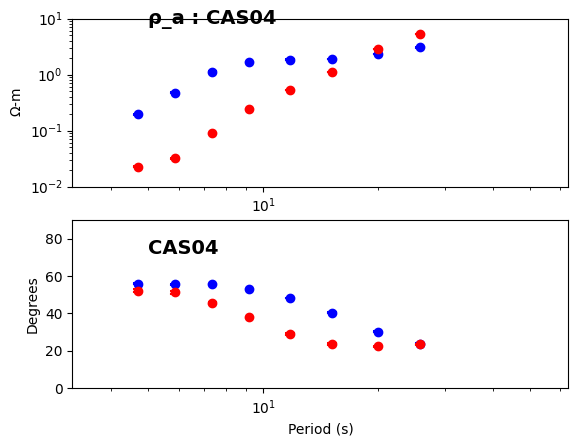

DECIMATION LEVEL 1
DATASET DF UPDATED
Skip saving FCs. dec_level_config.save_fc =  False
Skip saving FCs. dec_level_config.save_fc =  False
Processing band 102.915872s
Processing band 85.631182s
Processing band 68.881694s
Processing band 54.195827s
Processing band 43.003958s
Processing band 33.310722s


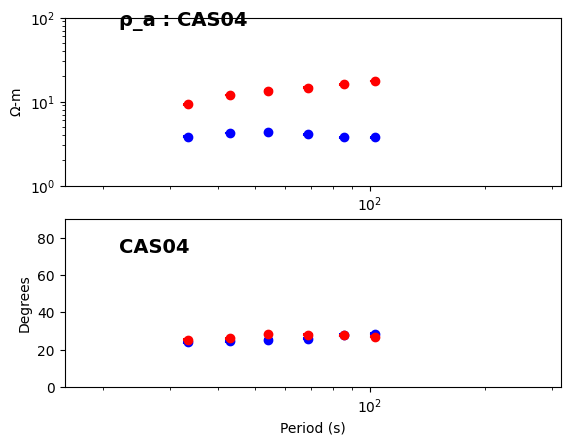

DECIMATION LEVEL 2
DATASET DF UPDATED
Skip saving FCs. dec_level_config.save_fc =  False
Skip saving FCs. dec_level_config.save_fc =  False
Processing band 411.663489s
Processing band 342.524727s
Processing band 275.526776s
Processing band 216.783308s
Processing band 172.015831s
Processing band 133.242890s


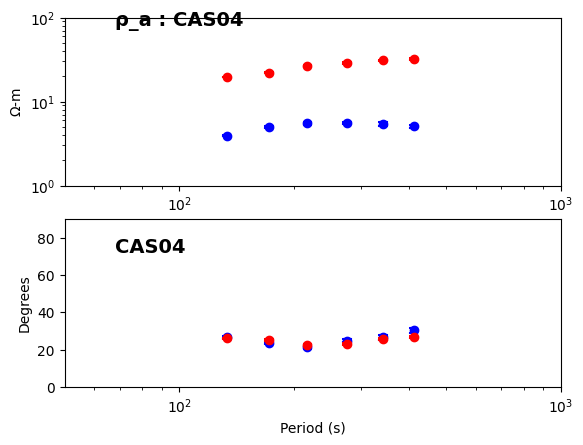

DECIMATION LEVEL 3
DATASET DF UPDATED
Skip saving FCs. dec_level_config.save_fc =  False
Skip saving FCs. dec_level_config.save_fc =  False
Processing band 1514.701336s
Processing band 1042.488956s
Processing band 723.371271s
Processing band 532.971560s
Processing band 412.837995s


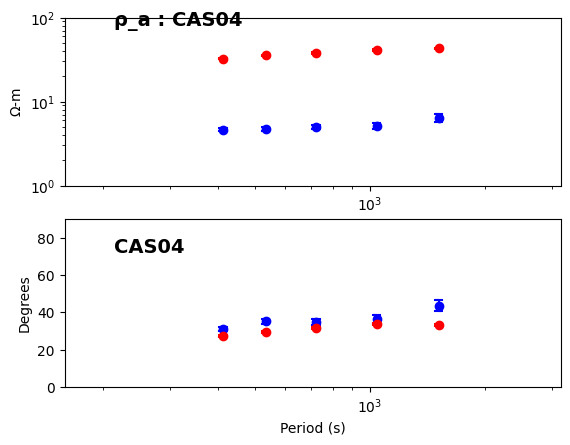

2023-10-31T13:40:14.123332-0700 | INFO | mth5.mth5 | close_mth5 | Flushing and closing /Users/laurakeyson/Desktop/aurora_test/aurora/docs/examples/8P_CAS04.h5


In [34]:
show_plot = True
tf_cls = process_mth5(config,
                    kernel_dataset,
                    units="MT",
                    show_plot=show_plot,
                    z_file_path=None,
                )

In [35]:

type(tf_cls)

Error in callback <bound method AutoreloadMagics.pre_run_cell of <IPython.extensions.autoreload.AutoreloadMagics object at 0x106932090>> (for pre_run_cell):


TypeError: AutoreloadMagics.pre_run_cell() takes 1 positional argument but 2 were given

mt_metadata.transfer_functions.core.TF

Write the transfer functions generated by the Aurora pipeline

In [36]:
 tf_cls.write(fn="emtfxml_test.xml", file_type="emtfxml")

Error in callback <bound method AutoreloadMagics.pre_run_cell of <IPython.extensions.autoreload.AutoreloadMagics object at 0x106932090>> (for pre_run_cell):


TypeError: AutoreloadMagics.pre_run_cell() takes 1 positional argument but 2 were given

EMTFXML(station='CAS04', latitude=37.63, longitude=-121.47, elevation=329.39)

In [37]:
tf_cls.write(fn="emtfxml_test.xml", file_type="edi")

Error in callback <bound method AutoreloadMagics.pre_run_cell of <IPython.extensions.autoreload.AutoreloadMagics object at 0x106932090>> (for pre_run_cell):


TypeError: AutoreloadMagics.pre_run_cell() takes 1 positional argument but 2 were given

EMTFXML(station='CAS04', latitude=37.63, longitude=-121.47, elevation=329.39)

In [38]:
 tf_cls.write(fn="emtfxml_test.xml", file_type="zmm")

Error in callback <bound method AutoreloadMagics.pre_run_cell of <IPython.extensions.autoreload.AutoreloadMagics object at 0x106932090>> (for pre_run_cell):


TypeError: AutoreloadMagics.pre_run_cell() takes 1 positional argument but 2 were given

EMTFXML(station='CAS04', latitude=37.63, longitude=-121.47, elevation=329.39)